
<br>
======================================================<br>
Face classification using Haar-like feature descriptor<br>
======================================================<br>
Haar-like feature descriptors were successfully used to implement the first<br>
real-time face detector [1]_. Inspired by this application, we propose an<br>
example illustrating the extraction, selection, and classification of Haar-like<br>
features to detect faces vs. non-faces.<br>
Notes<br>
-----<br>
This example relies on `scikit-learn <https://scikit-learn.org/>`_ for feature<br>
selection and classification.<br>
References<br>
----------<br>
.. [1] Viola, Paul, and Michael J. Jones. "Robust real-time face<br>
       detection." International journal of computer vision 57.2<br>
       (2004): 137-154.<br>
       https://www.merl.com/publications/docs/TR2004-043.pdf<br>
       :DOI:`10.1109/CVPR.2001.990517`<br>


In [1]:
import sys
from time import time

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from dask import delayed

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [5]:
from skimage.data import lfw_subset
from skimage.transform import integral_image
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature

#########################################################################<br>
The procedure to extract the Haar-like features from an image is relatively<br>
simple. Firstly, a region of interest (ROI) is defined. Secondly, the<br>
integral image within this ROI is computed. Finally, the integral image is<br>
used to extract the features.

In [6]:
@delayed
def extract_feature_image(img, feature_type, feature_coord=None):
    """Extract the haar feature for the current image"""
    ii = integral_image(img)
    return haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
                             feature_type=feature_type,
                             feature_coord=feature_coord)

#########################################################################<br>
We use a subset of CBCL dataset which is composed of 100 face images and<br>
100 non-face images. Each image has been resized to a ROI of 19 by 19<br>
pixels. We select 75 images from each group to train a classifier and<br>
determine the most salient features. The remaining 25 images from each<br>
class are used to assess the performance of the classifier.

In [7]:
images = lfw_subset()
# To speed up the example, extract the two types of features only
feature_types = ['type-2-x', 'type-2-y']

Build a computation graph using Dask. This allows the use of multiple<br>
CPU cores later during the actual computation

In [8]:
X = delayed(extract_feature_image(img, feature_types) for img in images)
# Compute the result
t_start = time()
X = np.array(X.compute(scheduler='single-threaded'))
time_full_feature_comp = time() - t_start

Label images (100 faces and 100 non-faces)

In [9]:
y = np.array([1] * 100 + [0] * 100)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=150,
                                                    random_state=0,
                                                    stratify=y)

Extract all possible features

In [11]:
feature_coord, feature_type = \
    haar_like_feature_coord(width=images.shape[2], height=images.shape[1],
                            feature_type=feature_types)

#########################################################################<br>
A random forest classifier can be trained in order to select the most<br>
salient features, specifically for face classification. The idea is to<br>
determine which features are most often used by the ensemble of trees.<br>
By using only the most salient features in subsequent steps, we can<br>
drastically speed up the computation while retaining accuracy.

Train a random forest classifier and assess its performance

In [12]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=None,
                             max_features=100, n_jobs=-1, random_state=0)
t_start = time()
clf.fit(X_train, y_train)
time_full_train = time() - t_start
auc_full_features = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

Sort features in order of importance and plot the six most significant

In [13]:
idx_sorted = np.argsort(clf.feature_importances_)[::-1]

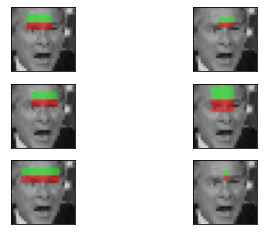

In [14]:
fig, axes = plt.subplots(3, 2)
for idx, ax in enumerate(axes.ravel()):
    image = images[0]
    image = draw_haar_like_feature(image, 0, 0,
                                   images.shape[2],
                                   images.shape[1],
                                   [feature_coord[idx_sorted[idx]]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

In [15]:
_ = fig.suptitle('The most important features')

#########################################################################<br>
We can select the most important features by checking the cumulative sum<br>
of the feature importance. In this example, we keep the features<br>
representing 70% of the cumulative value (which corresponds to using only 3%<br>
of the total number of features).

In [16]:
cdf_feature_importances = np.cumsum(clf.feature_importances_[idx_sorted])
cdf_feature_importances /= cdf_feature_importances[-1]  # divide by max value
sig_feature_count = np.count_nonzero(cdf_feature_importances < 0.7)
sig_feature_percent = round(sig_feature_count /
                            len(cdf_feature_importances) * 100, 1)
print(('{} features, or {}%, account for 70% of branch points in the '
       'random forest.').format(sig_feature_count, sig_feature_percent))

724 features, or 0.7%, account for 70% of branch points in the random forest.


Select the determined number of most informative features

In [17]:
feature_coord_sel = feature_coord[idx_sorted[:sig_feature_count]]
feature_type_sel = feature_type[idx_sorted[:sig_feature_count]]
# Note: it is also possible to select the features directly from the matrix X,
# but we would like to emphasize the usage of `feature_coord` and `feature_type`
# to recompute a subset of desired features.

Build the computational graph using Dask

In [18]:
X = delayed(extract_feature_image(img, feature_type_sel, feature_coord_sel)
            for img in images)
# Compute the result
t_start = time()
X = np.array(X.compute(scheduler='single-threaded'))
time_subs_feature_comp = time() - t_start

In [19]:
y = np.array([1] * 100 + [0] * 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=150,
                                                    random_state=0,
                                                    stratify=y)

#########################################################################<br>
Once the features are extracted, we can train and test a new classifier.

In [20]:
t_start = time()
clf.fit(X_train, y_train)
time_subs_train = time() - t_start

In [21]:
auc_subs_features = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

In [22]:
summary = (('Computing the full feature set took {:.3f}s, plus {:.3f}s '
            'training, for an AUC of {:.2f}. Computing the restricted '
            'feature set took {:.3f}s, plus {:.3f}s training, '
            'for an AUC of {:.2f}.')
           .format(time_full_feature_comp, time_full_train,
                   auc_full_features, time_subs_feature_comp,
                   time_subs_train, auc_subs_features))

In [23]:
print(summary)
plt.show()

Computing the full feature set took 81.748s, plus 2.735s training, for an AUC of 1.00. Computing the restricted feature set took 0.217s, plus 2.178s training, for an AUC of 1.00.
